In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import tensorflow as tf
import wordcloud

In [2]:
#loading dataset
dataset_file = "D:/Dataset/sms_spam/SMSSpamCollection.txt"
data = pd.read_csv(dataset_file, sep='\t')
data.head()

,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [3]:
data = pd.read_csv(dataset_file, sep='\t', header=None, names = ['isSpam', 'message'])
data['isSpam'].replace({'ham': 0, 'spam': 1}, inplace=True)
data.head()

,isSpam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
ham_message  = data[data['isSpam'] == 0].copy()
spam_message = data[data['isSpam'] == 1].copy()

In [5]:
print("ham data count", len(ham_message))
print("spam data count", len(spam_message))

ham data count 4825
spam data count 747


In [6]:
def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

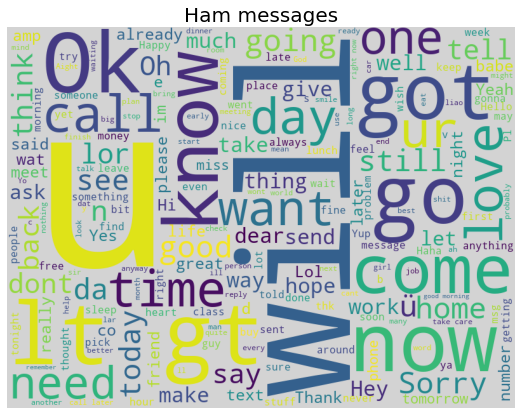

In [7]:
show_wordcloud(ham_message, "Ham messages")

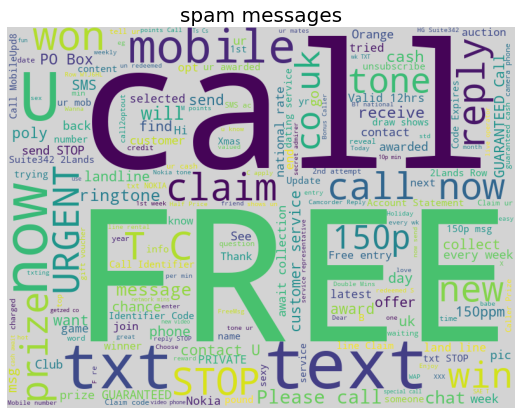

In [8]:
show_wordcloud(spam_message, "spam messages")

In [9]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [10]:
X = data['message'].values
y = data['isSpam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [12]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[87, 2, 172, 485, 461, 121, 33, 5, 3857, 3858, 315, 1268, 30, 2603, 67, 82, 2, 1657, 2, 316, 238], [246, 873, 15, 54, 8, 462, 160, 21, 25, 95, 1658, 77, 1, 61, 1120, 3859, 33, 174, 3, 53, 2604]]


In [13]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[2603   67   82 ...    2  316  238]
 [  61 1120 3859 ...    3   53 2604]
 [  49   85   97 ...    6  247   99]
 ...
 [1640   31 2485 ...  254   31 2486]
 [ 944 1460 1197 ...    0    0    0]
 [ 116   74   37 ...    9 3219 1396]]


In [14]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             190896    
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 500)               96500     
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [15]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 2s 6ms/step - loss: 0.1915 - accuracy: 0.9251 - val_loss: 0.0767 - val_accuracy: 0.9776
Epoch 2/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0487 - accuracy: 0.9854 - val_loss: 0.0557 - val_accuracy: 0.9857
Epoch 3/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0818 - val_accuracy: 0.9848
Epoch 4/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.1581 - val_accuracy: 0.9830
Epoch 5/50
140/140 [==============================] - 1s 5ms/step - loss: 4.1380e-04 - accuracy: 0.9998 - val_loss: 0.2164 - val_accuracy: 0.9848
Epoch 6/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.2551 - val_accuracy: 0.9839
Epoch 7/50
140/140 [==============================] - 1s 5ms/step - loss: 1.7294e-05 - accuracy: 1.0000 - val_loss: 0.2937 - val_accuracy: 0.983

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [17]:
preds = (model.predict(padded_test) > 0.7).astype("int32")

In [18]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9829596412556054


0.9829596412556054

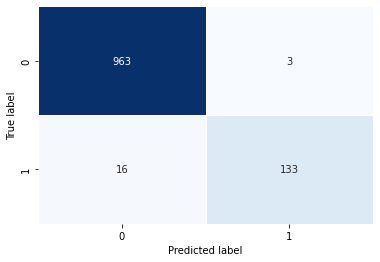

In [19]:
plot_confusion_matrix(y_test, preds)

In [20]:
model.save("spam_model")

INFO:tensorflow:Assets written to: spam_model\assets


In [21]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [22]:
def is_sms_spam(sms):
    s_model = tf.keras.models.load_model("spam_model")
    with open('spam_model/tokenizer.pkl', 'rb') as input:
        tokenizer = pickle.load(input)
    sms = [sms]
    sms_proc = t.texts_to_sequences(sms)
    sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
    pred = (model.predict(sms_proc) > 0.7).astype("int32").item()
    if pred == 1:
        print("Message is Spam")
    else:
        print("Message is not spam")

In [23]:
sms = "We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "
is_sms_spam(sms)

Message is Spam


In [24]:
sms = ["I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times"]
is_sms_spam(sms)

Message is not spam
